In [1]:
#! pip install yfinance --quiet

# * import libraries
# addition required libraries
import yfinance as yf
import pandas as pd
import numpy as np

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# tensorflow
from tensorflow.keras.layers import Dense, LSTM, Dropout, Normalization
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# interface
from IPython.display import display


# * read data
# retrieve data from Yahoo Finance
btc = yf.Ticker('btc-usd').history(period='2y', interval='1h')
btc.reset_index(inplace=True)

# rename 'index' to 'time'
btc.rename(columns={'index': 'Time'}, inplace=True)

# convert datatype
btc['Time'] = pd.to_datetime(btc['Time'])
btc['Open'] = btc['Open'].astype(float)
btc['High'] = btc['High'].astype(float)
btc['Low'] = btc['Low'].astype(float)
btc['Close'] = btc['Close'].astype(float)
btc['Volume'] = btc['Volume'].astype(float)


# * data exploration
# tail
print("Bitcoin last price:")
display(btc.tail())

# statistics
print("Bitcoin statistics:")
display(btc.describe())


     |████████████████████████████████| 6.4 MB 7.3 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
Bitcoin last price:


,Time,Open,High,Low,Close,Volume,Dividends,Stock Splits
17095,2022-01-14 23:00:00+00:00,43294.437500,43299.718750,43078.941406,43098.804688,0.0,0,0
17096,2022-01-15 00:00:00+00:00,43101.898438,43166.277344,43011.734375,43080.941406,0.0,0,0
17097,2022-01-15 01:00:00+00:00,43086.535156,43101.933594,42952.402344,42993.898438,0.0,0,0
17098,2022-01-15 02:00:00+00:00,42997.058594,43082.964844,42972.871094,43044.300781,11216896.0,0,0
17099,2022-01-15 02:52:00+00:00,43044.761719,43044.761719,43044.761719,43044.761719,0.0,0,0


Bitcoin statistics:


,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,17100.000000,17100.000000,17100.000000,17100.000000,1.710000e+04,17100.0,17100.0
mean,29957.400066,30097.590168,29812.325592,29959.355882,9.977107e+10,0.0,0.0
std,19551.281433,19647.775615,19450.028704,19551.028222,1.091916e+13,0.0,0.0
min,4467.192871,4671.898438,4106.980957,4454.060547,0.000000e+00,0.0,0.0
25%,9865.266846,9887.753174,9847.090820,9868.581787,0.000000e+00,0.0,0.0
50%,31933.715820,32165.284180,31750.822266,31951.820312,5.677056e+06,0.0,0.0
75%,47942.754883,48127.959961,47723.287109,47940.626953,3.391826e+08,0.0,0.0
max,68610.171875,68789.625000,68475.140625,68622.632812,1.410153e+15,0.0,0.0


In [2]:

# convert to X, y
def create_data(data, lookback):
    X, y = [], []
    for i in range(lookback, data.shape[0]):
        X.append(data[i-lookback:i].reshape(-1))
        y.append(data[i, 0])
    return np.array(X), np.array(y)


# * preprocessing data
# scale data
scaler = MinMaxScaler() 
value = scaler.fit_transform(btc.Close.values.reshape(-1, 1)) 

# initialize train test
train = value[:13664]
test = value[13664:]

# create X, y train test
X_train, y_train = create_data(train, 50)
X_test, y_test = create_data(test, 50)

# reshape X to 3D
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))           
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))   

# print shape and data of train set
print("X_train shape: ", X_train.shape)
print("y_train shape: ", len(y_train))
print("X_train (first 5 rows and columns):", X_train[:5, :5, :])
print("y_train: ", y_train)
print("=============="*10)

# print shape and data of test set
print("X_test shape: ", X_test.shape)
print("y_test shape: ", len(y_test))
print("X_test (first 5 rows and columns):", X_test[:5, :5, :])
print("y_test: ", y_test)


X_train shape:  (13614, 50, 1)
y_train shape:  13614
X_train (first 5 rows and columns): [[[0.06764394]
  [0.06861377]
  [0.06614219]
  [0.06597307]
  [0.06620415]]

 [[0.06861377]
  [0.06614219]
  [0.06597307]
  [0.06620415]
  [0.06595865]]

 [[0.06614219]
  [0.06597307]
  [0.06620415]
  [0.06595865]
  [0.0665517 ]]

 [[0.06597307]
  [0.06620415]
  [0.06595865]
  [0.0665517 ]
  [0.06687592]]

 [[0.06620415]
  [0.06595865]
  [0.0665517 ]
  [0.06687592]
  [0.06715999]]]
y_train:  [0.06751317 0.06867542 0.06907129 ... 0.68723896 0.69791475 0.69647622]
X_test shape:  (3386, 50, 1)
y_test shape:  3386
X_test (first 5 rows and columns): [[[0.69520546]
  [0.69757848]
  [0.70193876]
  [0.70350976]
  [0.70200019]]

 [[0.69757848]
  [0.70193876]
  [0.70350976]
  [0.70200019]
  [0.69313121]]

 [[0.70193876]
  [0.70350976]
  [0.70200019]
  [0.69313121]
  [0.69321053]]

 [[0.70350976]
  [0.70200019]
  [0.69313121]
  [0.69321053]
  [0.69737005]]

 [[0.70200019]
  [0.69313121]
  [0.69321053]
  [0.69

In [3]:

# * modeling
# create model
model = Sequential()

# adding layers
model.add(LSTM(50, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='relu')) # output layer

# compile model
model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae', 'accuracy'])
model.summary()

# fit modal
history_model1 = model.fit(X_train, y_train, epochs=100, batch_size=32)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
426/426 [==============================] - 13s 24ms/step - loss: 0.0024 - mse: 0.0024 - mae: 0.0273 - accuracy: 7.3454e-05
Epoch 2/100
426/426 [==============================] - 10s 24ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0193 - accuracy: 7.3454e-05
Epoch 3/100
426/426 [=========================

In [4]:

# * predict
def predict(model):
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)

    prediction = pd.DataFrame({'prediction': [np.NaN]*50, 'label': 'null'})
    prediction = pd.concat([prediction, pd.DataFrame(
        {"prediction": train_predict.reshape(-1), "label": "train"})], ignore_index=True)
    prediction = pd.concat([prediction, pd.DataFrame(
        {'prediction': [np.NaN]*50, 'label': 'null'})], ignore_index=True)
    prediction = pd.concat([prediction, pd.DataFrame(
        {"prediction": test_predict.reshape(-1), "label": "test"})], ignore_index=True)

    prediction['prediction'] = scaler.inverse_transform(
        prediction['prediction'].values.reshape(-1, 1))

    return pd.concat([btc, prediction], axis=1)


# * plot price line using seaborn
def plot_price(data):
    # set color palette
    sns.set_theme(style='darkgrid', palette='muted')

    # configure figure
    plt.figure(figsize=(12, 8))

    # plot line
    sns.lineplot(data=data, x='Time', y='Close')
    sns.lineplot(data=data, x='Time', y='prediction',
                 hue='label', palette='gist_ncar_r')

    # set legend box
    plt.legend(['Actual price', 'Null', 'Train prediction', 'Test prediction'])

    # set title
    plt.title('Bitcoin price and prediction')

    # set label
    plt.xlabel('Time')
    plt.ylabel('Price(USD)')


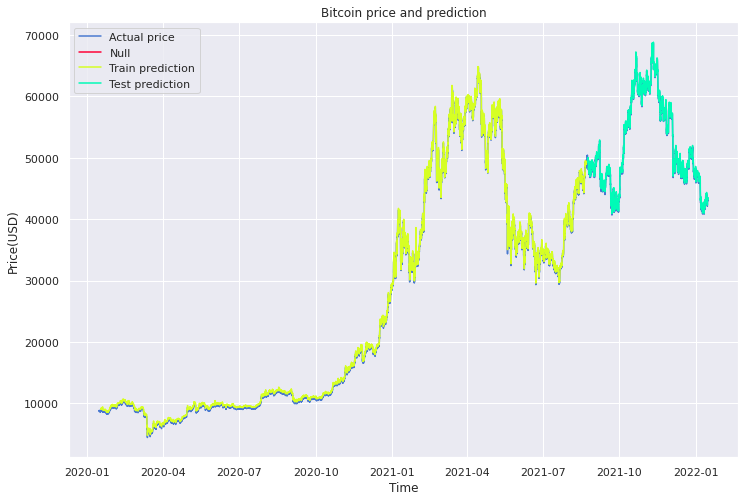

In [5]:
combination = predict(model)
plot_price(combination)

In [6]:

# * modeling
# create model
model = Sequential()

# adding layers
model.add(LSTM(50, input_shape=(X_train.shape[1], 1), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dropout(0.2))
model.add(Dense(1, activation='relu')) # output layer

# compile model
model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae', 'accuracy'])
model.summary()

# fit modal
history_model2 = model.fit(X_train, y_train, epochs=100, batch_size=32)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50, 50)            10400     
                                                                 
 dropout_1 (Dropout)         (None, 50, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50, 100)           60400     
                                                                 
 dropout_2 (Dropout)         (None, 50, 100)           0         
                                                                 
 lstm_3 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                

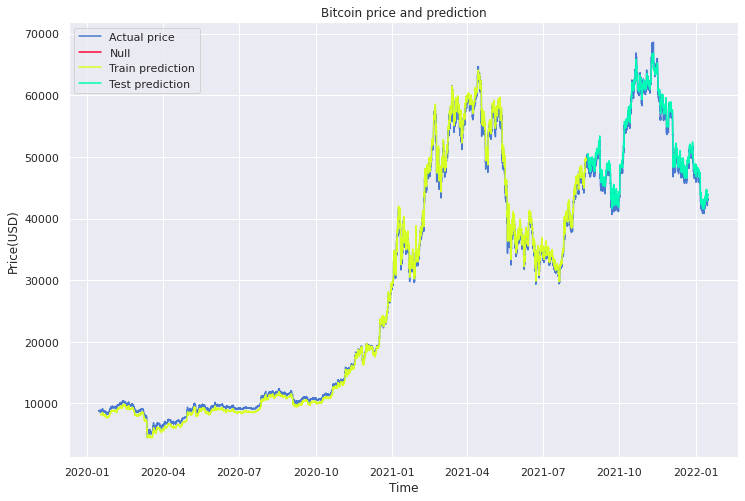

In [7]:
combination = predict(model)
plot_price(combination)

Text(0, 0.5, 'Loss value')

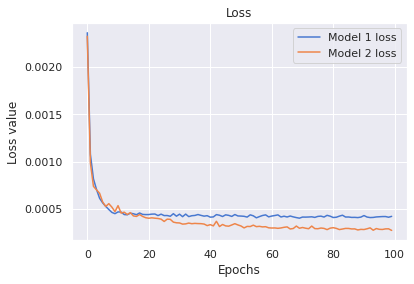

In [10]:
sns.lineplot(data=history_model1.history['loss'])
sns.lineplot(data=history_model2.history['loss'])
plt.title("Loss")
plt.legend(['Model 1 loss', 'Model 2 loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss value")